#1.Install Required Libraries

In [ ]:
# Install necessary libraries: TensorFlow (deep learning), Albumentations (image augmentation), Kaggle API
!pip install tensorflow albumentations kaggle

# 2.Upload & Configure Kaggle API Token


In [2]:
from google.colab import files
import os

# Upload kaggle.json manually — this is our Kaggle API token to access datasets
uploaded = files.upload()

# Create the directory where Kaggle expects the token to be stored
os.makedirs("/root/.kaggle", exist_ok=True)

# Save the uploaded token in the correct location
with open("/root/.kaggle/kaggle.json", "wb") as f:
    f.write(uploaded['kaggle.json'])

# Set permissions so that only the owner can read/write it — required by Kaggle
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


#3. Download & Unzip Dataset from Kaggle

In [3]:
# Download the dataset using the Kaggle CLI
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Unzip the dataset into a directory
!unzip -q covid19-radiography-database.zip -d covid19-radiography-dataset


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 89% 692M/778M [00:00<00:00, 1.37GB/s]
100% 778M/778M [00:00<00:00, 1.32GB/s]


# 4.Organize Dataset into Train/Test Splits

In [4]:
import os, shutil, random
from pathlib import Path

random.seed(42)  # For reproducibility of data splits

# Define source path and destination paths
source_dir = Path("/content/covid19-radiography-dataset/COVID-19_Radiography_Dataset")
dest_dir = Path("/content/data/processed")

# Separate training and test sets
train_dir = dest_dir / "train_data_with_masks"
test_dir = dest_dir / "test_data_with_masks"

# Class labels we're working with
classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
split_ratio = 0.85  # 85% training, 15% testing

for cls in classes:
    images_path = source_dir / cls / "images"
    masks_path = source_dir / cls / "masks"

    # Get all image filenames and shuffle for randomness
    images = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    # Split into train and test
    split_idx = int(len(images) * split_ratio)
    train_imgs, test_imgs = images[:split_idx], images[split_idx:]

    for subset, img_list in [('train', train_imgs), ('test', test_imgs)]:
        img_dest = (train_dir if subset == 'train' else test_dir) / cls / 'images'
        mask_dest = (train_dir if subset == 'train' else test_dir) / cls / 'masks'

        # Create folders if they don’t exist
        img_dest.mkdir(parents=True, exist_ok=True)
        mask_dest.mkdir(parents=True, exist_ok=True)

        # Copy images and corresponding masks (if they exist)
        for img in img_list:
            shutil.copy(images_path / img, img_dest / img)
            mask_path = masks_path / img
            if mask_path.exists():
                shutil.copy(mask_path, mask_dest / img)


# 5a.Prepare Training and Validation Datasets with stacked masks


In [5]:
import tensorflow as tf
import albumentations as A
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter

# Config
IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE = 224, 224, 16
CLASSES = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
CLASS_TO_INDEX = {cls: idx for idx, cls in enumerate(CLASSES)}
DATA_DIR = Path("/content/data/processed/train_data_with_masks")

# Albumentations augmentations
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5),
])

# ----------------------------------------
# Load image paths and labels
# ----------------------------------------
img_paths, labels = [], []
for cls in CLASSES:
    img_dir = DATA_DIR / cls / "images"
    for img_file in img_dir.glob("*"):
        img_paths.append(str(img_file))
        labels.append(CLASS_TO_INDEX[cls])

# Split
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    img_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Determine minority classes for augmentation
class_counts = Counter(train_labels)
mean_count = np.mean(list(class_counts.values()))
minority_classes = [cls for cls, count in class_counts.items() if count < mean_count]

#1) Dataset WITH stacked masks (image + mask + label)
# ----------------------------------------
# Image + mask loader
# ----------------------------------------
def load_image_and_mask(img_path, mask_path, augment_data=False):
    # Load grayscale image
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0

    # Apply mask to image (zero out non-lung regions)
    img = img * mask

    # Augment
    if augment_data:
        augmented = augment(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']

    # Stack: [img_R, img_G, img_B, mask]
    img_3ch = np.stack([img]*3, axis=-1)
    mask_ch = np.expand_dims(mask, axis=-1)
    img_with_mask = np.concatenate([img_3ch, mask_ch], axis=-1)  # Shape: (H, W, 4)

    return img_with_mask

# ----------------------------------------
# Generator
# ----------------------------------------
def classification_generator(img_paths, labels):
    for img_path, label in zip(img_paths, labels):
        img_path_obj = Path(img_path)
        mask_path = img_path_obj.parent.parent / "masks" / img_path_obj.name
        augment_flag = label in minority_classes
        img_with_mask = load_image_and_mask(img_path, mask_path, augment_data=augment_flag)
        yield img_with_mask, label

# ----------------------------------------
# Dataset creator
# ----------------------------------------
def create_classification_dataset(img_paths, labels, batch_size=16):
    dataset = tf.data.Dataset.from_generator(
        lambda: classification_generator(img_paths, labels),
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    return dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Final datasets (renaming for clarity)
train_dataset_stacked_masks = create_classification_dataset(train_imgs, train_labels, BATCH_SIZE)
val_dataset_stacked_masks = create_classification_dataset(val_imgs, val_labels, BATCH_SIZE)

print(f"Train batches: {len(list(train_dataset_stacked_masks))}")
print(f"Validation batches: {len(list(val_dataset_stacked_masks))}")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train batches: 900
Validation batches: 225


# 5b Prepare Training and Validation Datasets with masks as second input

In [6]:
import tensorflow as tf
import numpy as np
import cv2
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter

# Constants (modify as needed)
IMG_HEIGHT, IMG_WIDTH = 224, 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Make sure these exist in our code
# CLASSES = [...]
# CLASS_TO_INDEX = {...}
# DATA_DIR = Path("/your/data/path")
# augment = albumentations.Compose(...)  # assuming Albumentations is used

def build_file_list(data_root):
    image_paths, mask_paths, labels = [], [], []
    for cls in CLASSES:
        img_dir = Path(data_root) / cls / "images"  # Image directory for each class
        mask_dir = Path(data_root) / cls / "masks"  # Mask directory for each class
        for img_file in img_dir.glob("*"):  # Iterate over all image files
            image_paths.append(str(img_file))  # Store image file path
            mask_paths.append(str(mask_dir / img_file.name))  # Store corresponding mask path
            labels.append(CLASS_TO_INDEX[cls])  # Store class label (numerical)
    return image_paths, mask_paths, labels  # Return lists of paths and labels


all_img_paths, all_mask_paths, all_labels = build_file_list(DATA_DIR)  # Load all file paths and labels

# Split the data into training and validation subsets
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths, train_labels_mask, val_labels_mask = train_test_split(
    all_img_paths, all_mask_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)
# test_size=0.2 → 20% for validation
# stratify=all_labels → ensures class distribution is preserved

# Determine minority classes for targeted augmentation
class_counts_mask = Counter(train_labels_mask)  # Count frequency of each class in training set
mean_count = np.mean(list(class_counts_mask.values()))  # Compute average class frequency

# Find classes with fewer samples than the mean
minority_classes_mask = [cls for cls, count in class_counts_mask.items() if count < mean_count]


def load_and_preprocess(img_path, mask_path, label, augment_on=False):
    def _load_numpy(img_path_str, mask_path_str, label_int, apply_aug):
        # Read grayscale image and mask using OpenCV
        img = cv2.imread(img_path_str.decode(), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path_str.decode(), cv2.IMREAD_GRAYSCALE)

        # Resize both to standard size
        img = cv2.resize(img, IMG_SIZE)
        mask = cv2.resize(mask, IMG_SIZE)

        # Apply augmentation if flag is set
        if apply_aug:
            augmented = augment(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        # Normalize to [0, 1] and convert to float32
        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Convert grayscale image to 3 channels
        img = np.stack([img] * 3, axis=-1)
        # Add a channel dimension to the mask
        mask = np.expand_dims(mask, axis=-1)

        return img, mask, label_int  # Return processed image, mask, and label


    def py_func(img_path, mask_path, label, augment_flag):
       # Wrap the above numpy logic in a TensorFlow-compatible function
        return tf.py_function(
            func=lambda i, m, l, a: _load_numpy(i.numpy(), m.numpy(), l.numpy(), a.numpy()),
            inp=[img_path, mask_path, label, augment_flag],
            Tout=[tf.float32, tf.float32, tf.int32]
        )

    augment_flag = tf.cast(augment_on, tf.int32)  # Ensure augment flag is of correct type
    img, mask, label = py_func(img_path, mask_path, label, augment_flag) # Apply loading logic
    # Set static shapes for TensorFlow to know tensor sizes
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    label.set_shape([])

    return (img, mask), label # Return image/mask tuple and label


def make_dataset(img_paths, mask_paths, labels, batch_size=32, shuffle=True, is_training=False):
  # Create a dataset from file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the data

    def map_fn(img, mask, lbl):
        # Use numpy logic to check if it's a minority class
        def is_minority(label_tensor):
            label_val = label_tensor.numpy()
            return np.int32(label_val in minority_classes_mask)
        # Wrap in py_function so it works in TensorFlow
        augment_flag = tf.py_function(is_minority, [lbl], tf.int32)
        augment_flag.set_shape([])
        # Apply preprocessing function
        return load_and_preprocess(img, mask, lbl, augment_on=augment_flag)

    # Apply map transformation in parallel for performance
    dataset = dataset.map(map_fn, num_parallel_calls=AUTOTUNE)

    # Batch and prefetch for efficient training
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    return dataset


# Build datasets
# Build training dataset with optional augmentation for minorities
train_dataset_with_mask = make_dataset(train_img_paths, train_mask_paths, train_labels_mask, BATCH_SIZE, shuffle=True, is_training=True)

# Build validation dataset (no shuffling, no augmentation needed)
val_dataset_with_mask = make_dataset(val_img_paths, val_mask_paths, val_labels_mask, BATCH_SIZE, shuffle=False, is_training=True)

# Evaluate batches to print count (WARNING: can be slow for large datasets)
print(f"Train batches: {len(list(train_dataset_with_mask))}")
print(f"Validation batches: {len(list(val_dataset_with_mask))}")



Train batches: 900
Validation batches: 225


# 6. Prepare Test Data (Images + Masks)


In [7]:
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
from pathlib import Path

TEST_DATA_DIR = Path("/content/data/processed/test_data_with_masks")

# Initialize lists to store test images, masks, and labels
X_test, y_test = [], []
mask_list = []

# Load test images and labels
# Loop through each class defined in CLASSES (defined globally)
for cls_index, cls in enumerate(CLASSES):
    img_dir = TEST_DATA_DIR / cls / "images"
    mask_dir = TEST_DATA_DIR / cls / "masks"

    img_files = sorted(img_dir.glob("*"))  # sort to keep order consistent with masks
    mask_files = sorted(mask_dir.glob("*"))

    # Iterate over paired image and mask files
    for img_file, mask_file in zip(img_files, mask_files):
        # Load grayscale image and mask, resize handled by load_img
        img = load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        mask = load_img(mask_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')

        # Convert image and mask to NumPy arrays and normalize pixel values to [0, 1]
        img_array = img_to_array(img).astype(np.float32) / 255.0
        mask_array = img_to_array(mask).astype(np.float32) / 255.0

        # Convert grayscale to 3-channel RGB by repeating the same channel
        img_array = np.repeat(img_array, 3, axis=-1)

        # Append data to corresponding lists
        X_test.append(img_array)
        mask_list.append(mask_array)
        y_test.append(cls_index) ## Store numeric label for the class

# Convert to numpy arrays for efficient batch processing
X_test = np.array(X_test, dtype=np.float32)
test_masks = np.array(mask_list, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

# Define a function to explicitly set shapes for TensorFlow's static shape inference
def set_shapes(inputs, label):
    img, mask = inputs
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    label.set_shape([])  # scalar
    return (img, mask), label

# Create TensorFlow Dataset object from arrays of images, masks, and labels
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test, test_masks), y_test))

# Apply the shape-setting function to each element in the dataset
test_dataset = test_dataset.map(set_shapes)

# Batch the dataset and enable prefetching for performance
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



#7a. 1st  Model -Build a CNN model

In [82]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

#Define a function to build the CNN model
def build_4ch_cnn_model(input_shape=(224, 224, 4), num_classes=4):
    inputs = Input(shape=input_shape) # Input layer expecting 224x224x4 tensors
#Convolutional Block 1
    x = Conv2D(32, (3,3), padding='same')(inputs)       # Conv layer with 32 filters, 3x3 kernel
    x = BatchNormalization()(x)                         # Normalize activations to stabilize training
    x = Activation('relu')(x)                           # Apply ReLU activation
    x = MaxPooling2D(pool_size=(2,2))(x)                # Downsample feature maps by 2x

#Convolutional Block 2
    x = Conv2D(64, (3,3), padding='same')(x)            # Conv layer with 64 filters
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

#Convolutional Block 3
    x = Conv2D(128, (3,3), padding='same')(x)           # Conv layer with 128 filters
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
# Global Feature Aggregation
    x = GlobalAveragePooling2D()(x)                     # Reduce each feature map to a single value
#Fully Connected Layers
    x = Dense(256, activation='relu')(x)                # Fully connected layer with 256 units + ReLU
    x = Dropout(0.3)(x)                                 # Drop 30% of units randomly during training

    x = Dense(128, activation='relu')(x)                # Fully connected layer with 128 units
    x = Dropout(0.3)(x)                                 # Dropout to reduce overfitting


    outputs = Dense(num_classes, activation='softmax')(x) # Output layer for classification

    model = Model(inputs, outputs)  # Create the Keras model
    return model                    # Return the model instance

model = build_4ch_cnn_model()       # Build model with default args
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   # Compile the model with optimizer, loss and metrics
model.summary()                     # Print the model architecture and parameters


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,868 (628.39 KB)

 Trainable params: 160,420 (626.64 KB)

 Non-trainable params: 448 (1.75 KB)

#Train model with callbacks

In [83]:
EPOCHS = 20
history = model.fit(
    train_dataset_stacked_masks,
    validation_data=val_dataset_stacked_masks,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3)
    ]
)


Epoch 1/20
    900/Unknown 64s 65ms/step - accuracy: 0.6162 - loss: 0.9502

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 79s 81ms/step - accuracy: 0.6162 - loss: 0.9500 - val_accuracy: 0.6092 - val_loss: 1.3732 - learning_rate: 0.0010
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 70s 77ms/step - accuracy: 0.7609 - loss: 0.6284 - val_accuracy: 0.3168 - val_loss: 2.1054 - learning_rate: 0.0010
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 69s 76ms/step - accuracy: 0.7821 - loss: 0.5731 - val_accuracy: 0.3291 - val_loss: 3.0738 - learning_rate: 0.0010
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 69s 76ms/step - accuracy: 0.8145 - loss: 0.5161 - val_accuracy: 0.6923 - val_loss: 0.8090 - learning_rate: 0.0010
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 68s 75ms/step - accuracy: 0.8349 - loss: 0.4670 - val_accuracy: 0.7993 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 68s 75ms/step - accuracy: 0.8478 - loss: 0.4399 - val_accuracy: 0.5781 - val_loss: 1.1572 - learning_rate: 0.0010
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 68s 75ms/step - accuracy: 0.8419 - loss: 0.4452

In [85]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Gather predictions
y_true = []  # Ground truth labels
y_pred = []  # Model predicted labels

for batch in val_dataset_stacked_masks:
    imgs, labels = batch            # `imgs` is a batch of input tensors; `labels` are the true class indices
    preds = model.predict(imgs)     # Predict probabilities for each class
    y_true.extend(labels.numpy())   # Convert true labels from tensors to numpy and add to list
    y_pred.extend(np.argmax(preds, axis=1))  # Choose the class with highest probability

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

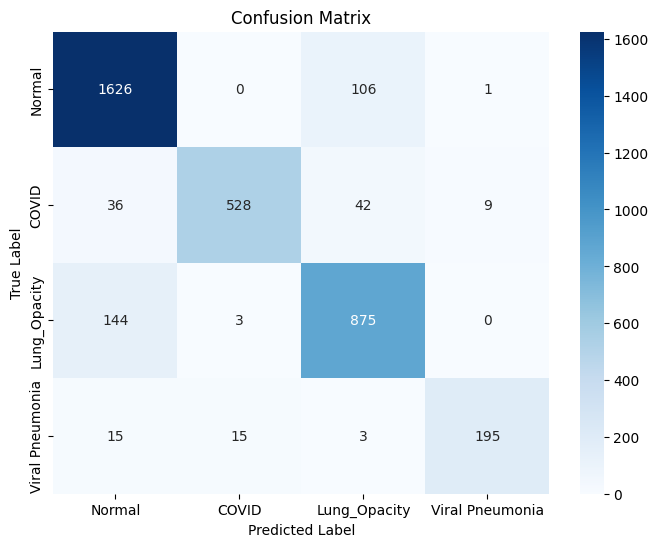

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot epoch loss and accuracy

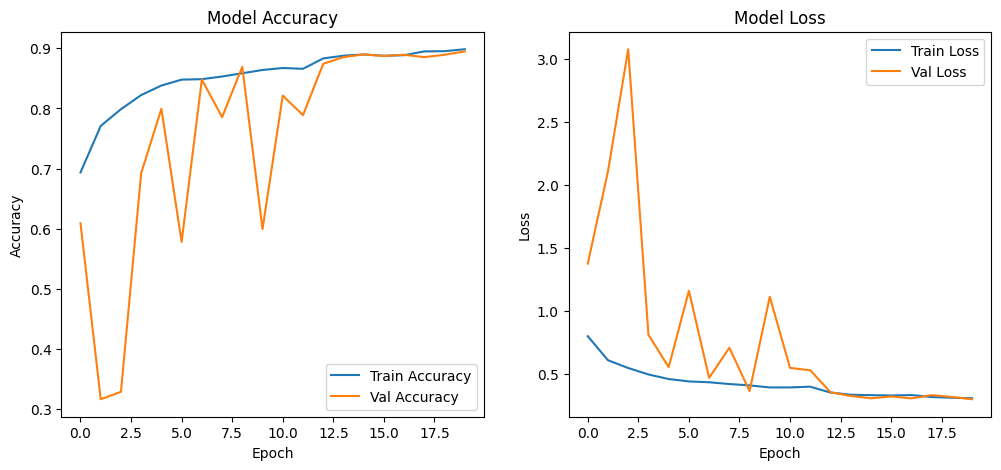

In [87]:
#plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#Save model to google drive

In [88]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/model_cnnmask1.keras'
model.save(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 7b) 2nd Model: Build a VGG16-Based Classification Model with Attention from Lung Segmentation Masks

#load tf.data Dataset with Mask-Attention Pairs


In [26]:
# train and validation datasets used for this
train_dataset_with_mask = make_dataset(train_img_paths, train_mask_paths, train_labels_mask, BATCH_SIZE, shuffle=True, is_training=True)
val_dataset_with_mask = make_dataset(val_img_paths, val_mask_paths, val_labels_mask, BATCH_SIZE, shuffle=False, is_training=True)


# Build VGG16 Classifier with Mask-Based Attention

In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, Multiply, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda, Multiply, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
import tensorflow as tf

def build_model():
    # Define model inputs
    #two inputs:RGB image (3 channels),Segmentation mask (1 channel)
    rgb_input = Input(shape=(224, 224, 3), name="image_input")
    mask_input = Input(shape=(224, 224, 1), name="mask_input")  # Binary or soft mask

    # Load pre-trained VGG16 backbone (excluding top layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=rgb_input)

    # Partially freeze model (fine-tune last 8 layers)
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    # Get last conv output
    feature_map = base_model.get_layer("block5_conv3").output  # shape: (14, 14, 512)

    # Resize mask to match feature map shape
    mask_resized = Lambda(lambda x: tf.image.resize(x, (14, 14)), name="resize_mask")(mask_input)

    # Apply mask to feature map
    attention_map = Multiply(name="attention")([feature_map, mask_resized])

    # Classification head
    x = GlobalAveragePooling2D()(attention_map)  # Converts features into a 1D vector.
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax', name="predictions")(x)

    model = Model(inputs=[rgb_input, mask_input], outputs=output)
    model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   # Low learning rate for fine-tuning

    return model


In [33]:
# View architecture
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,772,996 (60.17 MB)

 Trainable params: 14,034,436 (53.54 MB)

 Non-trainable params: 1,738,560 (6.63 MB)

#Train the Model with Callbacks

In [34]:
history = model.fit(
    train_dataset_with_mask,
    validation_data=val_dataset_with_mask,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),  # Stop if no improvement
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2),  # Reduce LR on plateau
        tf.keras.callbacks.ModelCheckpoint("best_masked_attention_model.h5", save_best_only=True)  # Save best model
    ]
)


Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6643 - loss: 1.0063

900/900 ━━━━━━━━━━━━━━━━━━━━ 241s 246ms/step - accuracy: 0.6645 - loss: 1.0060 - val_accuracy: 0.7979 - val_loss: 0.5842 - learning_rate: 1.0000e-05
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8637 - loss: 0.4345

900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 226ms/step - accuracy: 0.8637 - loss: 0.4345 - val_accuracy: 0.8963 - val_loss: 0.3125 - learning_rate: 1.0000e-05
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 202s 225ms/step - accuracy: 0.8975 - loss: 0.3396 - val_accuracy: 0.9022 - val_loss: 0.3159 - learning_rate: 1.0000e-05
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9031 - loss: 0.3051

900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 226ms/step - accuracy: 0.9031 - loss: 0.3050 - val_accuracy: 0.9175 - val_loss: 0.2917 - learning_rate: 1.0000e-05
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9128 - loss: 0.2684

900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 226ms/step - accuracy: 0.9128 - loss: 0.2684 - val_accuracy: 0.9216 - val_loss: 0.2492 - learning_rate: 1.0000e-05
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9204 - loss: 0.2355

900/900 ━━━━━━━━━━━━━━━━━━━━ 204s 227ms/step - accuracy: 0.9204 - loss: 0.2355 - val_accuracy: 0.9361 - val_loss: 0.2193 - learning_rate: 1.0000e-05
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 225ms/step - accuracy: 0.9237 - loss: 0.2289 - val_accuracy: 0.9058 - val_loss: 0.4172 - learning_rate: 1.0000e-05
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9334 - loss: 0.2108

900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 226ms/step - accuracy: 0.9334 - loss: 0.2108 - val_accuracy: 0.9308 - val_loss: 0.2094 - learning_rate: 1.0000e-05
Epoch 9/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 225ms/step - accuracy: 0.9463 - loss: 0.1636 - val_accuracy: 0.8949 - val_loss: 0.3689 - learning_rate: 1.0000e-05
Epoch 10/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 226ms/step - accuracy: 0.9486 - loss: 0.1586 - val_accuracy: 0.9269 - val_loss: 0.2631 - learning_rate: 1.0000e-05
Epoch 11/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 226ms/step - accuracy: 0.9611 - loss: 0.1142 - val_accuracy: 0.9272 - val_loss: 0.2263 - learning_rate: 2.0000e-06
Epoch 12/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 226ms/step - accuracy: 0.9660 - loss: 0.0995 - val_accuracy: 0.9330 - val_loss: 0.2166 - learning_rate: 2.0000e-06
Epoch 13/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9700 - loss: 0.0867

900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 225ms/step - accuracy: 0.9700 - loss: 0.0867 - val_accuracy: 0.9411 - val_loss: 0.2034 - learning_rate: 4.0000e-07
Epoch 14/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9750 - loss: 0.0761

900/900 ━━━━━━━━━━━━━━━━━━━━ 201s 224ms/step - accuracy: 0.9750 - loss: 0.0761 - val_accuracy: 0.9416 - val_loss: 0.2023 - learning_rate: 4.0000e-07
Epoch 15/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 225ms/step - accuracy: 0.9699 - loss: 0.0930 - val_accuracy: 0.9405 - val_loss: 0.2048 - learning_rate: 4.0000e-07
Epoch 16/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9766 - loss: 0.0731

900/900 ━━━━━━━━━━━━━━━━━━━━ 202s 225ms/step - accuracy: 0.9766 - loss: 0.0731 - val_accuracy: 0.9450 - val_loss: 0.2001 - learning_rate: 4.0000e-07
Epoch 17/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9737 - loss: 0.0813

900/900 ━━━━━━━━━━━━━━━━━━━━ 203s 226ms/step - accuracy: 0.9737 - loss: 0.0813 - val_accuracy: 0.9441 - val_loss: 0.1999 - learning_rate: 4.0000e-07
Epoch 18/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 202s 225ms/step - accuracy: 0.9772 - loss: 0.0706 - val_accuracy: 0.9411 - val_loss: 0.2061 - learning_rate: 4.0000e-07
Epoch 19/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 201s 224ms/step - accuracy: 0.9782 - loss: 0.0675 - val_accuracy: 0.9439 - val_loss: 0.2069 - learning_rate: 4.0000e-07
Epoch 20/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 202s 224ms/step - accuracy: 0.9735 - loss: 0.0862 - val_accuracy: 0.9411 - val_loss: 0.2089 - learning_rate: 8.0000e-08


In [37]:
import numpy as np

# Get predictions
y_true = []
y_pred = []

for (img_batch, mask_batch), label_batch in val_dataset_with_mask:
    preds = model.predict([img_batch, mask_batch])
    y_true.extend(label_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

# Classification and Confusion Matrix

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.94      0.95      0.95      1733
          COVID       0.97      0.99      0.98       615
   Lung_Opacity       0.92      0.90      0.91      1022
Viral Pneumonia       0.98      0.97      0.98       228

       accuracy                           0.94      3598
      macro avg       0.95      0.95      0.95      3598
   weighted avg       0.94      0.94      0.94      3598



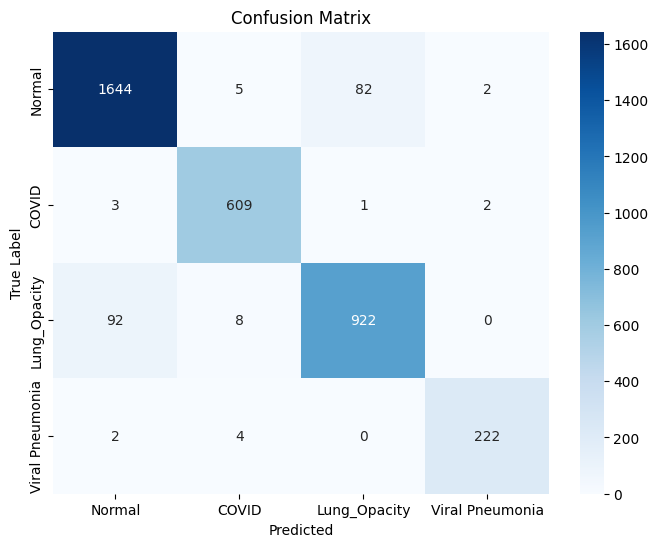

In [55]:
import seaborn as sns
# Step 2: Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Epoch Accuracy and loss

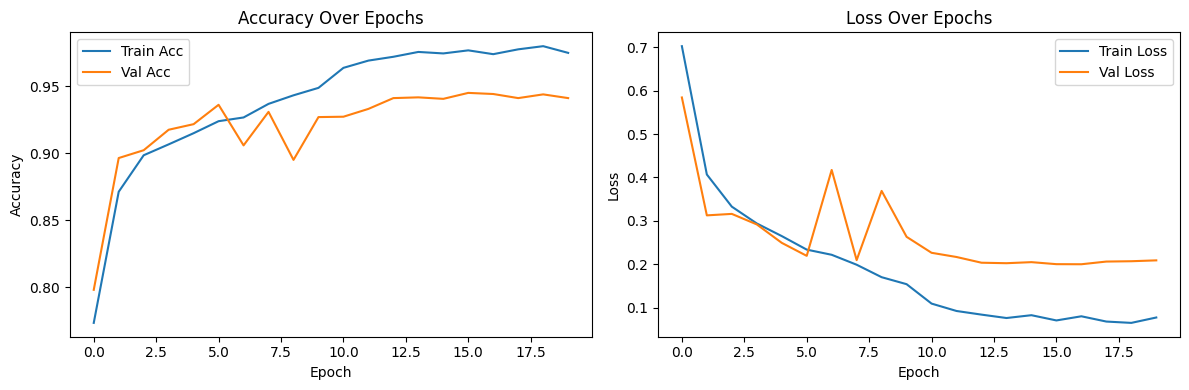

In [39]:
import matplotlib.pyplot as plt

# Assuming `history` is your training history object
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


#Save the Model to Google Drive

In [40]:
from google.colab import drive
drive.mount('/content/drive')

# Save in Keras native format (.keras)
model_path = "/content/drive/MyDrive/best_masked_attention_model.keras"
model.save(model_path)

print(f"Model saved to: {model_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/best_masked_attention_model.keras


# 8) ENSEMBLE Voting


# Load model1 and model2

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
# Load first model (4-channel CNN) - this is fine
model1 = tf.keras.models.load_model('/content/drive/MyDrive/model_cnnmask1.keras', compile=False)


# Load attention model with weights
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, Multiply, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_attention_model():
    # Inputs
    rgb_input = Input(shape=(224, 224, 3), name="image_input")
    mask_input = Input(shape=(224, 224, 1), name="mask_input")  # Binary or soft mask

    # Load base VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=rgb_input)

    # Freeze most layers
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    # Extract features from last conv layer
    feature_map = base_model.get_layer("block5_conv3").output  # (14, 14, 512)

    # Resize mask to match feature map shape
    mask_resized = Lambda(lambda x: tf.image.resize(x, (14, 14)), name="resize_mask")(mask_input)

    # Apply mask to feature map
    attention_map = Multiply(name="attention")([feature_map, mask_resized])

    # Classification head
    x = GlobalAveragePooling2D()(attention_map)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax', name="predictions")(x)

    # Define final model
    model = Model(inputs=[rgb_input, mask_input], outputs=output)

    # Compile the model
    model.compile(
        optimizer=Adam(1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Now build model2 and load weights
model2 = build_attention_model()
model2.load_weights('/content/drive/MyDrive/best_masked_attention_weights.weights.h5')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Run Average Ensemble Prediction On Test dataset

# Voting Ensemble

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --------- Load or Build Models ---------

# Load model1 (4-channel CNN)
model1 = tf.keras.models.load_model('/content/drive/MyDrive/model_cnnmask1.keras', compile=False)

# Rebuild model2 (VGG16 + attention)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, Multiply, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_attention_model():
    rgb_input = Input(shape=(224, 224, 3), name="image_input")
    mask_input = Input(shape=(224, 224, 1), name="mask_input")

    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=rgb_input)

    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    feature_map = base_model.get_layer("block5_conv3").output
    mask_resized = Lambda(lambda x: tf.image.resize(x, (14, 14)), name="resize_mask")(mask_input)
    attention_map = Multiply(name="attention")([feature_map, mask_resized])

    x = GlobalAveragePooling2D()(attention_map)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax', name="predictions")(x)

    model = Model(inputs=[rgb_input, mask_input], outputs=output)
    model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model2 = build_attention_model()
model2.load_weights('/content/drive/MyDrive/best_masked_attention_weights.weights.h5')

# --------- Wrap in VotingEnsemble ---------

@tf.keras.utils.register_keras_serializable()
class VotingEnsemble(tf.keras.Model):
    def __init__(self, model1, model2, **kwargs):
        super(VotingEnsemble, self).__init__(**kwargs)
        self.model1 = model1
        self.model2 = model2

    def call(self, inputs):
        rgb, mask = inputs
        image_with_mask = tf.concat([rgb, mask], axis=-1)
        pred1 = self.model1(image_with_mask)
        pred2 = self.model2([rgb, mask])
        return (pred1 + pred2) / 2.0

    def get_config(self):
        # We don't include model1 and model2 here because they can't be serialized automatically
        base_config = super(VotingEnsemble, self).get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
        # We cannot reconstruct model1 and model2 automatically here
        raise NotImplementedError(
            "Cannot load VotingEnsemble from config because model1 and model2 need to be passed explicitly."
        )

# Note: Save sub-models separately and load them when reloading ensemble
# Save ensemble architecture only (optional)
ensemble_model = VotingEnsemble(model1, model2)
_ = ensemble_model([tf.zeros((1, 224, 224, 3)), tf.zeros((1, 224, 224, 1))])  # Build model
ensemble_model.save("/content/drive/MyDrive/voting_ensemble_model.keras", save_format="keras")

# --------- Load and Evaluate ---------

# Load test data
# X_test, test_masks, y_test should already be defined
X_test = np.array(X_test, dtype=np.float32)
test_masks = np.array(test_masks, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

# Create dataset
BATCH_SIZE = 32
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test, test_masks), y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load sub-models first
loaded_model1 = tf.keras.models.load_model('/content/drive/MyDrive/model_cnnmask1.keras', compile=False)
loaded_model2 = build_attention_model()
loaded_model2.load_weights('/content/drive/MyDrive/best_masked_attention_weights.weights.h5')

# Instantiate ensemble manually (cannot load ensemble directly due to sub-models)
loaded_ensemble = VotingEnsemble(loaded_model1, loaded_model2)

# Run inference
# Run inference
all_preds = []
all_probs = []
all_labels = []

for (rgb_batch, mask_batch), labels_batch in test_dataset:
    probs = loaded_ensemble([rgb_batch, mask_batch])
    preds = tf.argmax(probs, axis=1).numpy()

    all_preds.extend(preds)
    all_probs.extend(probs.numpy())
    all_labels.extend(labels_batch.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Evaluation
print(f"\nEnsemble Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']))



Ensemble Accuracy: 0.9203

Confusion Matrix:
[[1457   17   47    8]
 [  21  506   15    1]
 [ 121   10  771    0]
 [  12    1    0  189]]

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.90      0.95      0.93      1529
          COVID       0.95      0.93      0.94       543
   Lung_Opacity       0.93      0.85      0.89       902
Viral Pneumonia       0.95      0.94      0.94       202

       accuracy                           0.92      3176
      macro avg       0.93      0.92      0.93      3176
   weighted avg       0.92      0.92      0.92      3176



# 9) Interpretibility

#Collect raw input images, masks, and labels from the test set

In [11]:
# Make sure imgs and masks are already defined (validation/test set)
# imgs: shape (N, 224, 224, 3), masks: shape (N, 224, 224, 1)
# Ensure lists are initialized
y_true = []
imgs_list = []
masks_list = []

# Loop over test dataset to collect inputs and labels
for (imgs, masks), labels in test_dataset:
    y_true.extend(labels.numpy())
    imgs_list.extend(imgs.numpy())
    masks_list.extend(masks.numpy())

# Convert to numpy arrays
imgs = np.array(imgs_list)
masks = np.array(masks_list)
y_true = np.array(y_true)

# Create 4-channel inputs for model1
imgs_4ch = np.concatenate([imgs, masks], axis=-1)



#GRADCAM

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_6']]
Received: inputs=Tensor(shape=(1, 224, 224, 4))
  warnings.warn(msg)


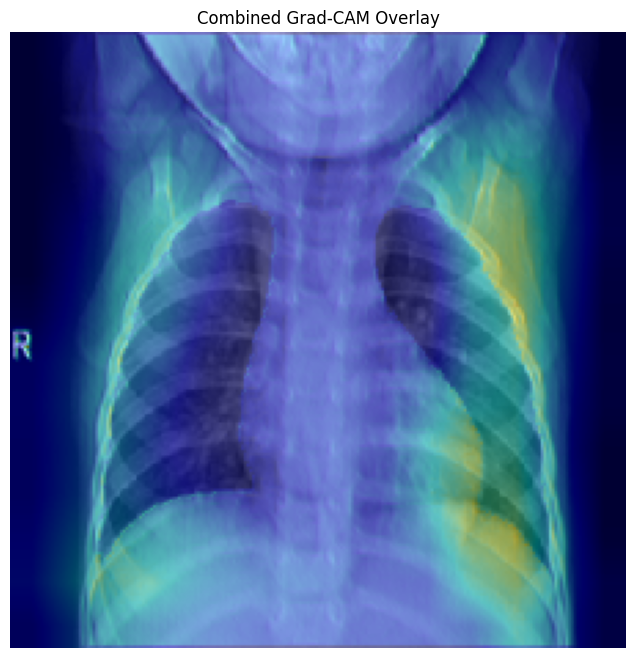

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for a single model.

    Args:
      model: tf.keras Model
      img_array: input image, shape (1, H, W, C)
      last_conv_layer_name: string, name of last conv layer in the model
      pred_index: class index to generate Grad-CAM for. If None, use top predicted class.

    Returns:
      heatmap: 2D numpy array (H, W) normalized to [0,1]
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
 #Create a sub-model that outputs both feature maps and final predictions.
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

#Compute gradients of the predicted class w.r.t. the convolutional output.
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#Calculate the importance of each channel via global average pooling over the gradients.
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)  # ReLU
    heatmap /= tf.reduce_max(heatmap) + 1e-10
    heatmap = heatmap.numpy()

    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlay heatmap on image.

    Args:
      img: Original image (H,W,3), uint8 or float 0-1
      heatmap: 2D array, values [0,1]

    Returns:
      overlayed image
    """
    #Converts normalized heatmap to a colormap, blends with the image using transparency.
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)

    if img.dtype != np.uint8:
        img_uint8 = np.uint8(255 * img)
    else:
        img_uint8 = img

    overlayed = cv2.addWeighted(heatmap_color, alpha, img_uint8, 1 - alpha, 0)
    return overlayed

# === used on one image ===

# Provide the last conv layer names for each model
last_conv_layer_name_model1 = 'conv2d_2'  # Last conv layer in 4-ch CNN
last_conv_layer_name_model2 = 'block5_conv3'  # Last conv in VGG16

# For model1 (4 channels)
img_4ch_input = np.expand_dims(imgs_4ch[0], axis=0)  # (1,224,224,4)

# For model2 (2 inputs)
img_3ch_input = np.expand_dims(imgs[0], axis=0)     # (1,224,224,3)
mask_input = np.expand_dims(masks[0], axis=0)       # (1,224,224,1)

# Compute Grad-CAMs for both models
heatmap1 = get_gradcam_heatmap(model1, img_4ch_input, last_conv_layer_name_model1)
# Fix input shape warning by wrapping inputs as a list of inputs list
heatmap2 = get_gradcam_heatmap(model2, [[img_3ch_input, mask_input]], last_conv_layer_name_model2)

# Match both heatmap sizes before combining
# Resize smaller heatmap to bigger one's shape
heatmap2_resized = cv2.resize(heatmap2, (heatmap1.shape[1], heatmap1.shape[0]))

combined_heatmap = (heatmap1 + heatmap2_resized) / 2.0

# Overlay Grad-CAM heatmap on the original RGB image
overlayed_img = overlay_heatmap(imgs[0], combined_heatmap)


plt.figure(figsize=(8,8))
plt.imshow(overlayed_img[..., ::-1])  # BGR to RGB
plt.axis('off')
plt.title("Combined Grad-CAM Overlay")
plt.show()


# Generate Grid plot

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_6']]
Received: inputs=Tensor(shape=(1, 224, 224, 4))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['image_input', 'mask_input']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))', 'Tensor(shape=(1, 224, 224, 1))']
  warnings.warn(msg)


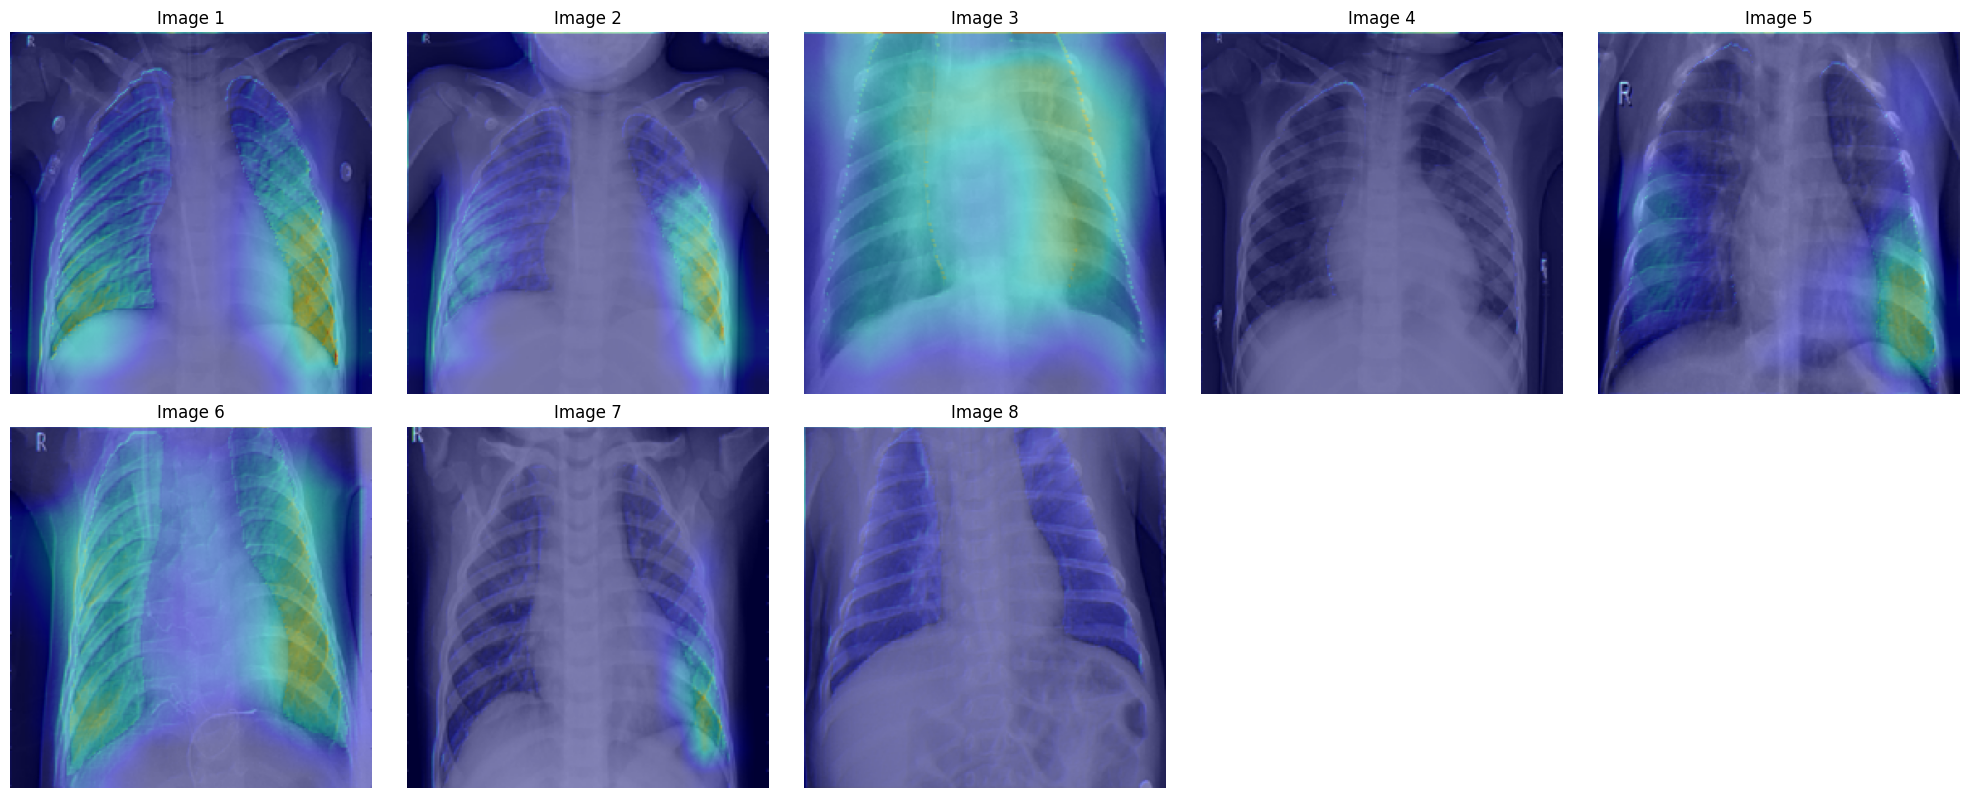

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_gradcam_grid(imgs, masks, imgs_4ch, model1, model2, last_conv_layer_name_model1, last_conv_layer_name_model2, n_images=15, rows=3, cols=5):
    plt.figure(figsize=(cols*4, rows*4))

    # Ensure n_images doesn't exceed dataset size
    n_images = min(n_images, imgs.shape[0])

    for i in range(n_images):
        # Prepare inputs for model1 and model2
        img_4ch_input = np.expand_dims(imgs_4ch[i], axis=0)  # Shape: (1, 224, 224, 4)
        img_3ch_input = np.expand_dims(imgs[i], axis=0)      # Shape: (1, 224, 224, 3)
        mask_input = np.expand_dims(masks[i], axis=0)        # Shape: (1, 224, 224, 1)

        # For model2, inputs should be a list of tensors matching model input signature
        inputs_model2 = [img_3ch_input, mask_input]

        # Get heatmaps
        heatmap1 = get_gradcam_heatmap(model1, img_4ch_input, last_conv_layer_name_model1)
        heatmap2 = get_gradcam_heatmap(model2, inputs_model2, last_conv_layer_name_model2)

        # Resize heatmap2 to heatmap1's spatial size
        heatmap2_resized = cv2.resize(heatmap2, (heatmap1.shape[1], heatmap1.shape[0]))

        # Combine heatmaps (average)
        combined_heatmap = (heatmap1 + heatmap2_resized) / 2.0

        # Overlay heatmap on original 3-channel image
        overlayed_img = overlay_heatmap(imgs[i], combined_heatmap)

        # Plot the result
        plt.subplot(rows, cols, i+1)
        plt.imshow(overlayed_img[..., ::-1])  # Convert BGR to RGB for matplotlib
        plt.axis('off')
        plt.title(f'Image {i+1}')

    plt.tight_layout()
    plt.show()
plot_gradcam_grid(imgs, masks, imgs_4ch, model1, model2, last_conv_layer_name_model1, last_conv_layer_name_model2, n_images=15, rows=3, cols=5)

#Confindence score

In [13]:
# Confidence score for each prediction (highest probability)
confidences = np.max(all_probs, axis=1)

# Example: print top-5 lowest confidence predictions
low_conf_indices = np.argsort(confidences)[:5]
for idx in low_conf_indices:
    print(f"True: {all_labels[idx]}, Pred: {all_preds[idx]}, Confidence: {confidences[idx]:.4f}")



True: 2, Pred: 2, Confidence: 0.3431
True: 0, Pred: 1, Confidence: 0.3517
True: 2, Pred: 0, Confidence: 0.3549
True: 0, Pred: 0, Confidence: 0.3602
True: 1, Pred: 1, Confidence: 0.3653


#Confidence Distribution plot

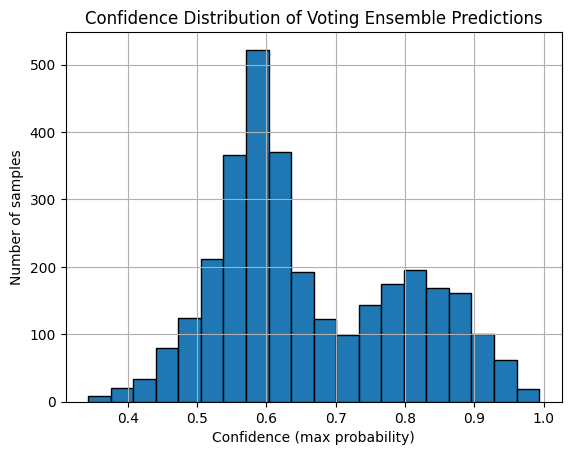

In [14]:
import matplotlib.pyplot as plt

plt.hist(confidences, bins=20, edgecolor='k')
plt.xlabel("Confidence (max probability)")
plt.ylabel("Number of samples")
plt.title("Confidence Distribution of Voting Ensemble Predictions")
plt.grid(True)
plt.show()


#Caliberation Curve

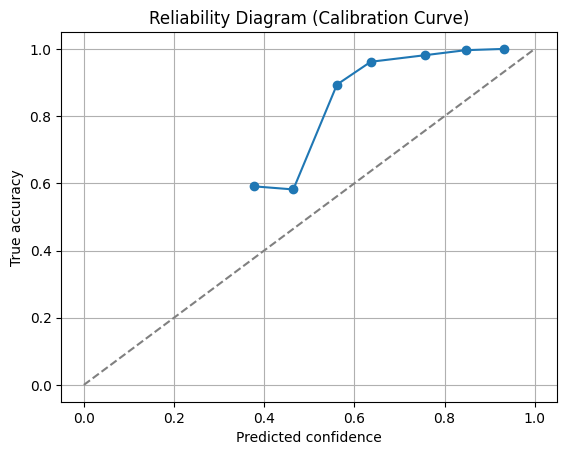

In [15]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve((all_labels == all_preds).astype(int), confidences, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Predicted confidence")
plt.ylabel("True accuracy")
plt.title("Reliability Diagram (Calibration Curve)")
plt.grid(True)
plt.show()


# Per-Class Confidence Analysis

In [18]:
import pandas as pd

df = pd.DataFrame({
    'True': all_labels,
    'Pred': all_preds,
    'Confidence': confidences
})

class_names = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
for i, name in enumerate(class_names):
    class_df = df[df['True'] == i]
    print(f"\n{name} - Avg Confidence: {class_df['Confidence'].mean():.4f}")



Normal - Avg Confidence: 0.5830

COVID - Avg Confidence: 0.7786

Lung_Opacity - Avg Confidence: 0.7041

Viral Pneumonia - Avg Confidence: 0.7938


#Run Prediction and Get Errors

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Run predictions
pred_probs = ensemble_model.predict([X_test, test_masks])
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = y_test

# Find incorrect predictions
wrong_idx = np.where(pred_labels != true_labels)[0]


100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 285ms/step


# Visualize Misclassified Images with Confidence

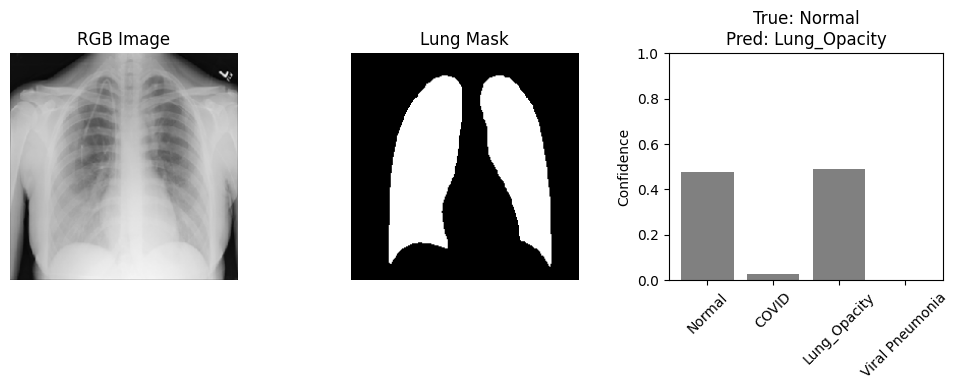

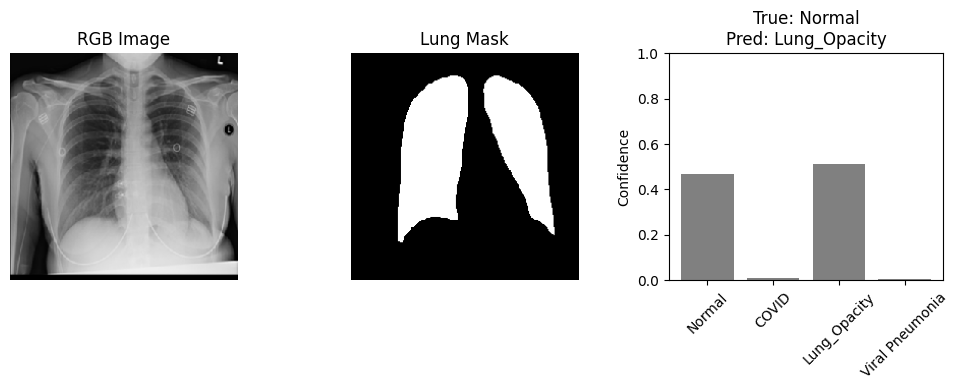

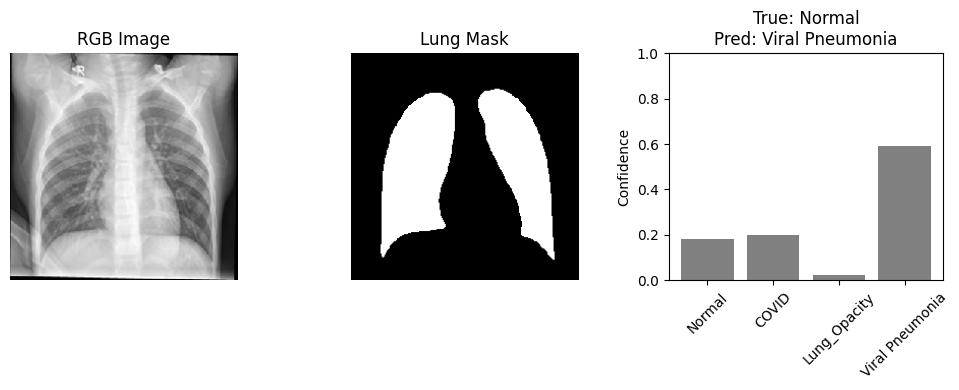

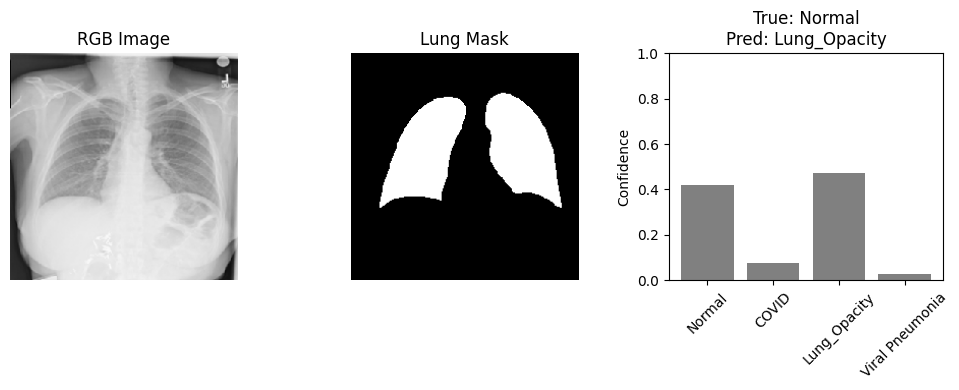

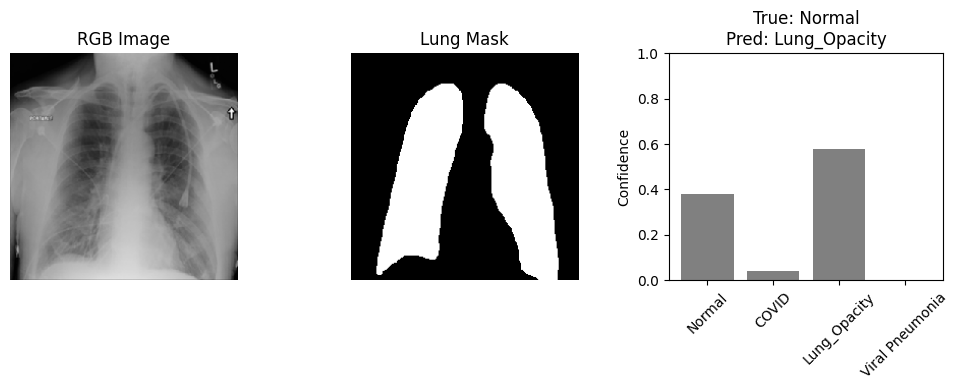

In [20]:
def plot_error_image(index, X, mask, true, pred, probs, class_names):
    plt.figure(figsize=(10, 4))

    # RGB Image
    plt.subplot(1, 3, 1)
    plt.imshow(X[index])
    plt.title("RGB Image")
    plt.axis('off')

    # Mask (if applicable)
    plt.subplot(1, 3, 2)
    plt.imshow(mask[index].squeeze(), cmap='gray')
    plt.title("Lung Mask")
    plt.axis('off')

    # Error Summary
    plt.subplot(1, 3, 3)
    plt.bar(class_names, probs[index], color='gray')
    plt.xticks(rotation=45)
    plt.title(f"True: {class_names[true[index]]}\nPred: {class_names[pred[index]]}")
    plt.ylim(0, 1)
    plt.ylabel("Confidence")

    plt.tight_layout()
    plt.show()

# Example: plot first 5 errors
for i in wrong_idx[:5]:
    plot_error_image(i, X_test, test_masks, y_test, pred_labels, pred_probs, class_names)
